# Chapter 6: Joins, Pivots, and USGS dataRetrieval

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2025-12-09

# Joins, Pivots, and USGS dataRetrieval

Use Template Repository from
github:<https://github.com/VT-Hydroinformatics/6-Get-Format-Plot-HydroData>

Readings: Introduction to the dataRetrieval package
<https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html>

Chapter 12 & 13 of R for Data Science
<https://r4ds.had.co.nz/tidy-data.html>

## Goals for today

-   Get familiar with the dataRetrieval package
-   Intro to joins
-   Learn about long vs. wide data and how to change between them

Prep question: How would you get data from the USGS NWIS (non-R)?

Install the dataRetrieval package. Load it and the tidyverse.

In [ ]:
#install.packages("dataRetrieval")
library(dataRetrieval)
library(tidyverse)

## Exploring what dataRetrieval can do.

Think about the dataRetrieval as a way to interact with same public data
you can access through waterdata.usgs.gov but without having to click on
buttons and search around. It makes getting data or doing analyses with
USGS data much more reproducible and fast!

To explore a few of the capabilities (NOT ALL!!) we will start with the
USGS gage on the New River at Radford. The gage number is 03171000.

The documentation for the package is extremely helpful:
<https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html>

I always have to look up how to do things because the package is very
specialized! This is the case with most website APIs, in my experience.
It’s a good argument for getting good at navigating package
documentation! Basically you just look through and try to piece together
the recipe for what you want to do using the examples they give in the
document.

First, let’s get information about the site using the readNWISsite() and
whatNWISdata() functions. Try each out and see what they tell you.

Remember, all the parameter codes and site names get passed to
dataRetrieval functions as characters, so they must be in quotes.

In [ ]:
#important: note the site number gets input as a character
site <- "03171000"

#Information about the site
siteinfo <- readNWISsite(site)

read_waterdata_monitoring_location

GET: https://waterservices.usgs.gov/nwis/site/?siteOutput=Expanded&format=rdb&site=03171000

read_waterdata_ts_meta

GET: https://waterservices.usgs.gov/nwis/site/?seriesCatalogOutput=true&sites=03171000

  agency_cd  site_no               station_nm site_tp_cd dec_lat_va dec_long_va
2      USGS 03171000 NEW RIVER AT RADFORD, VA         ST   37.14179   -80.56922
3      USGS 03171000 NEW RIVER AT RADFORD, VA         ST   37.14179   -80.56922
4      USGS 03171000 NEW RIVER AT RADFORD, VA         ST   37.14179   -80.56922
  coord_acy_cd dec_coord_datum_cd  alt_va alt_acy_va alt_datum_cd   huc_cd
2            U              NAD83 1711.99       0.13       NAVD88 05050001
3            U              NAD83 1711.99       0.13       NAVD88 05050001
4            U              NAD83 1711.99       0.13       NAVD88 05050001
  data_type_cd parm_cd stat_cd  ts_id loc_web_ds medium_grp_cd parm_grp_cd
2           dv   00010   00003 241564         NA           wat        <NA>
3           dv   00060   00003 145684         NA           wat        <NA>
4           dv   00095   00003 145685         NA           wat        <NA>
   srs_id access_cd begin_date   end_date count_nu
2 1645597         0 2006-12-2

## Joins

When we look at what whatNWISdata returns, we see it gives us parameter
codes, but doesn’t tell us what they mean. This is a common attribute of
databases: you use a common identifier but then have the full
information in a lookup file. In this case, the look-up information
telling us what the parameter codes mean is in “parameterCdFile” which
loads with the dataRetrieval package.

So, you could look at that and see what the parameters mean.

OR We could have R do it and add a column that tells us what the
parameters mean. Enter JOINS!

Joins allow us to combine the data from two different data sets that
have a column in common. At its most basic, a join looks for a matching
row with the same key in both datasets (for example, a USGS gage number)
and then combines the rows. So now you have all the data from both sets,
matched on the key.

But you have to make some decisions: what if a key value exists in one
set but not the other? Do you just drop that observation? Do you add an
NA? Let’s look at the different options.

Take for example the two data sets, FlowTable and SizeTable. The
SiteName values are the key values and the MeanFlow and WSsize values
are the data.

<img src="./images/joinsetup.png" alt="Join Setup" width="400">

Figure 1: Join Setup

Note River1 and River2 match up, but River3 and River5 only exist in one
data set or the other.

The first way to deal with this is an **INNER JOIN: inner_join()** In an
inner join, you only keep records that match. So the rows for River3 and
River5 will be dropped because there is no corresponding data in the
other set. See below:

<img src="./images/innerjoin.png" alt="Inner Join" width="1000">

Figure 2: Basic ggplot syntax

But what if you don’t want to lose the values in one or the other or
both?!

For instance, let’s say you have a bunch of discharge data for a stream,
and then chemistry grab samples. You want to join the chemistry to the
discharge based on the dates and times they were taken. But when you do
this, you don’t want to delete all the discharge data where there is no
chemistry! We need another option. Enter OUTER JOINS

**LEFT JOIN, left_join():** Preserves all values from the LEFT data set,
and pastes on the matching ones from the right. This creates NAs where
there is a value on the left but not the right. (this is what you’d want
to do in the discharge - chemistry example above)

<img src="./images/leftjoin1.png" alt="Left Join" width="1000">

Figure 3: Left Join

**RIGHT JOIN, right_join():** Preserves all values from the RIGHT data
set, and pastes on the matching ones from the left. This creates NAs
where there is a value on the right but not the left.

<img src="./images/rightjoin.png" alt="Right Join" width="1000">

Figure 4: Right Join

**FULL JOIN, full_join():** KEEP EVERYTHING! The hoarder of the joins.
No matching record on the left? create an NA on the right! No matching
value on the right? Create an NA on the left! NAs for everyone!

<img src="./images/fulljoin.png" alt="Full Join" width="1000">

Figure 5: Full Join

When you do this in R, you use the functions identified in the
descriptions with the following syntax (see example below):

**if the column is named the same in both data sets** \>
xxx_join(left_tibble, right_tibble, by = “key_column”)\*\*

**if the column is named differently in both data sets** \>
xxx_join(left_tibble, right_tibble, by = c(“left_key” = “right_key”)

<img src="./images/leftjoin2.png" alt="Left Join Differing Col Names" width="1000">

Figure 6: Left Join with differing column names

Note in both of the above, when you specify which column to use as “by”
you have to put it in quotes.

## Join example

So in the chunk below let’s get add information about the parameters in
dataAvailable by joining it with the key file: parameterCdFile. The
column with the parameter codes is called parm_cd in dataAvailable and
parameter_cd in parameterCdFile

In [ ]:
dataAvailable <- left_join(dataAvailable, parameterCdFile, 
                           by = c("parm_cd" = "parameter_cd"))

dataAvailable

  agency_cd  site_no               station_nm site_tp_cd dec_lat_va dec_long_va
1      USGS 03171000 NEW RIVER AT RADFORD, VA         ST   37.14179   -80.56922
2      USGS 03171000 NEW RIVER AT RADFORD, VA         ST   37.14179   -80.56922
3      USGS 03171000 NEW RIVER AT RADFORD, VA         ST   37.14179   -80.56922
  coord_acy_cd dec_coord_datum_cd  alt_va alt_acy_va alt_datum_cd   huc_cd
1            U              NAD83 1711.99       0.13       NAVD88 05050001
2            U              NAD83 1711.99       0.13       NAVD88 05050001
3            U              NAD83 1711.99       0.13       NAVD88 05050001
  data_type_cd parm_cd stat_cd  ts_id loc_web_ds medium_grp_cd parm_grp_cd
1           dv   00010   00003 241564         NA           wat        <NA>
2           dv   00060   00003 145684         NA           wat        <NA>
3           dv   00095   00003 145685         NA           wat        <NA>
   srs_id access_cd begin_date   end_date count_nu parameter_group_nm
1 1645597 

   site_no               station_nm parm_cd                  srsname
1 03171000 NEW RIVER AT RADFORD, VA   00010       Temperature, water
2 03171000 NEW RIVER AT RADFORD, VA   00060 Stream flow, mean. daily
3 03171000 NEW RIVER AT RADFORD, VA   00095     Specific conductance
  parameter_units begin_date   end_date
1           deg C 2006-12-20 2009-03-18
2           ft3/s 1907-10-01 2025-12-08
3      uS/cm @25C 2006-12-20 2008-09-29

## Finding IDs to download USGS data

You can find sites via map and just enter the id like we did in the
chunks above: <https://maps.waterdata.usgs.gov/mapper/index.html>

Below we will look at two other ways to get sites: using a bounding box
of a geographic region, or search terms like State and drainage area

In [ ]:
#find sites in a bounding box
#coords of bottom left, top right
swva <- c(-81.36, 36.72, -80.27, 37.32)

#get sites in this bounding box that have daily water temperature and discharge
swva_sites <- whatNWISsites(bBox = swva, 
                            parameterCd = c("00060", "00010"), 
                            hasDataTypeCd = "dv")

read_waterdata_monitoring_location

GET: https://waterservices.usgs.gov/nwis/site/?bBox=-81.36%2C36.72%2C-80.27%2C37.32&parameterCd=00060%2C00010&hasDataTypeCd=dv&format=mapper

Waiting 2s for throttling delay ■■■■■■■■■■■■■■■■                

Waiting 2s for throttling delay ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 

   agency_cd  site_no                                      station_nm
1       USGS 03473500             M F HOLSTON RIVER AT GROSECLOSE, VA
2       USGS 03175140         WEST FORK COVE CREEK NEAR BLUEFIELD, VA
3       USGS 03177710              BLUESTONE RIVER AT FALLS MILLS, VA
4       USGS 03177700                BLUESTONE RIVER AT BLUEFIELD, VA
5       USGS 03166000                  CRIPPLE CREEK NEAR IVANHOE, VA
6       USGS 03164500                      NEW RIVER NEAR GRAYSON, VA
7       USGS 03165500                        NEW RIVER AT IVANHOE, VA
8       USGS 03166880  WEST SP AT NAT FISH HAT NEAR GRAHAMS FORGE, VA
9       USGS 03166800                GLADE CREEK AT GRAHAMS FORGE, VA
10      USGS 03166900 BOILING SP AT NAT FISH HAT NR GRAHAMS FORGE, VA
11      USGS 03167000                 REED CREEK AT GRAHAMS FORGE, VA
12      USGS 03175500                     WOLF CREEK NEAR NARROWS, VA
13      USGS 03168500                       PEAK CREEK AT PULASKI, VA
14      USGS 0316800

GET: https://api.waterdata.usgs.gov/samples-data/codeservice/states?mimeType=application%2Fjson

read_waterdata_daily.

GET: https://waterservices.usgs.gov/nwis/dv/?stateCd=VA&parameterCd=00060&drainAreaMax=20&statCd=00003&format=waterml%2C1.1

## OK let’s download some data!

We are going to use readNWISdv(), which downloads daily values.

We will tell it which sites to download, which parameters to download,
and then what time period to download.

siteNumber gets the sites we want to download, USGS site numbers, as a
character. We will use the swva_sites data we generated (yep, you can
download multiple sites at once!)

startDate and endDate get the…. start and end dates. IMPORTANT: These
must be in YYY-MM-DD format, but you don’t have to tell R they are dates
before you give them to the function, it’ll do that for you.

parameterCd is the parameters you want to download. We want water
temperature and discharge, which are “00060” and “00010”, respectively.

Once we have the data, the column names correspond to the keys that
identify them, for example, discharge will be 00060 something something.
Fortunately the dataRetrieval package also provides
“renameNWISColumns()” which translates these into words, making them
more easily understood by humans. We can pipe the results of our
download to that function after we get the data to make the column names
easier to understand.

In [ ]:
start <- "2006-10-01"
end <- "2008-09-30"
params <- c("00010", "00060")

swva_dat <- readNWISdv(siteNumber = swva_sites$site_no, 
                       parameterCd = params, 
                       startDate = start, 
                       endDate = end) |> 
            renameNWISColumns()

read_waterdata_daily.

GET: https://waterservices.usgs.gov/nwis/dv/?site=03473500%2C03175140%2C03177710%2C03177700%2C03166000%2C03164500%2C03165500%2C03166880%2C03166800%2C03166900%2C03167000%2C03175500%2C03168500%2C03168000%2C03167500%2C03172500%2C03173000%2C03171500%2C03171000%2C03170000%2C03169500&format=waterml%2C1.1&ParameterCd=00010%2C00060&StatCd=00003&startDT=2006-10-01&endDT=2008-09-30

Let’s plot the water temperature data as a line and control the color of
the lines with the different sites.

What could be better about this plot?

(`geom_line()`).

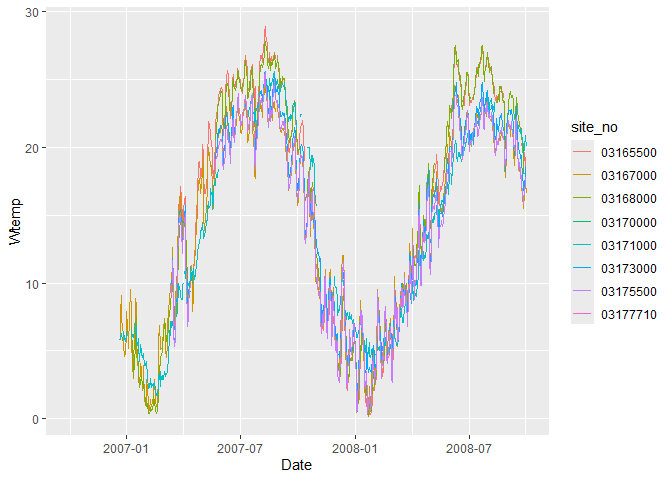

In [ ]:
swva_dat |> ggplot(aes(x = Date, y = Wtemp, color = site_no)) +
  geom_line()

We can add site names with….More joins! Our swva_sites data has the
names of the sites in human-friendly language. The column in the
downloaded data and in the swva_sites data is called “site_no” so we
just give that to the “by” argument. Perform a left join to add the
names of the sites to the data.

Then use select to remove some of the unnecessary columns.

Then make the plot and then snazz it up with labels and a non-junky
theme.

(`geom_line()`).

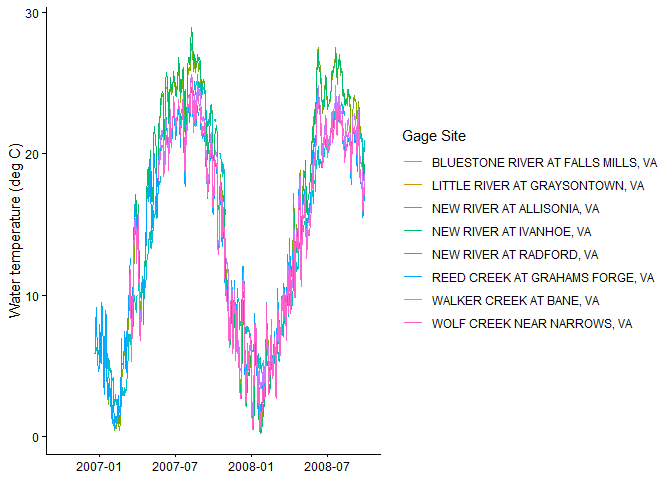

In [ ]:
swva_dat_clean <- left_join(swva_dat, swva_sites, by = "site_no") |>
  select(station_nm, site_no, Date, Flow, Wtemp, dec_lat_va, dec_long_va)

swva_dat_clean |> ggplot(aes(x = Date, y = Wtemp, color = station_nm)) +
  geom_line()+
  ylab("Water temperature (deg C)")+
  xlab(element_blank())+
  labs(color = "Gage Site")+
  theme_classic()

## Pivoting: wide and long data

Okay, so with the data above: what would you do if you wanted to
subtract the discharge or temperature of one gage from another on the
same river: to compute rate of change between the two sites, for
instance.

You could split them into two objects, then join based on date?

Or…now hear me out… you could PIVOT them.

A two-dimensional object can be either long or wide. Each has it’s
advantages.

**LONG**

Each observation has it’s own row. In the first image below, the table
on the right is long because each measurement has it’s own row. It’s
value and name are identified by a other columns, and the values in that
column repeat a lot.

**WIDE**

Observations of different things have their own columns. In the first
image below, notice in the left hand table there are “Flow”, “Temp”, and
“NO3” columns rather than an identifier in a separate column like in the
table on the right.

**Why?**

Long and wide data are more efficient for different things. Think about
plotting a data set with 10 stream gages. If they are in a long format,
you can just add color = Gage to your ggplot aes(). If they are in a
wide format, meaning each gage has it’s own column, you’d have to write
a new geom for EACH gage, because they’re all in separate columns.

Now imagine you want to do some math to create new data: let’s say cases
NO3 multiplied by Flow…. How would you even do that using the data on
the right? With the wide data on the left it is simply mutate(NO3 \*
Flow).

Finally, which table is easier to read in TABLE format (not a plot) in
each of the two images below? Wide data is much more fitting for tables.

<img src="./images/pivot_longer.png" alt="Pivoting to a longer format" width="1000">

Figure 7: Pivoting to a longer format”

<img src="./images/pivot_wider.png" alt="Pivoting to a wider format" width="1000">

Figure 8: Pivoting to a wider format

dplyr, part of the tidyverse, has functions to convert data between wide
and long data. I have to look up the syntax every single time I use
them. But they are VERY useful.

## Pivot Examples

Back to our original question: I want to subtract the flow at Ivanhoe
from the flow at Radford on the new river to see how much flow increases
between the two sites through time.

To do this I am going to use pivot_wider() to give Ivanhoe and Radford
discharges their own column.

First, we will use select to trim the data to just what we need, then
call pivot_wider telling it which data to use for the new column names
(names_from = station_nm) and what values we want to pivot into the data
under those columns (values_from = Flow).

Then, subtract the two and make a plot!

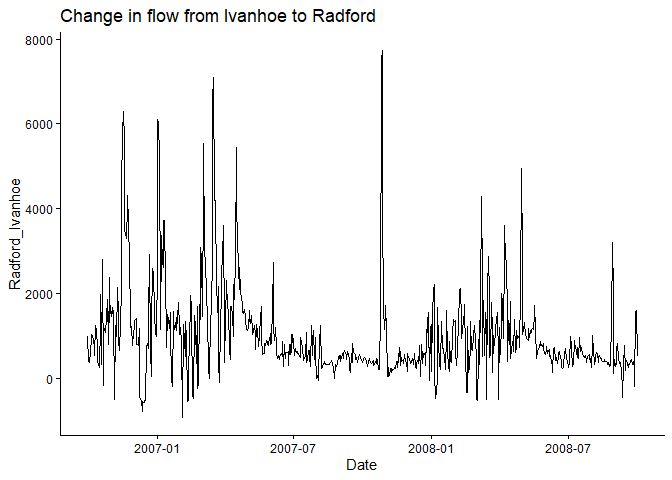

In [ ]:
#Pivot so we can compute diffs between one river and others

swva_wide <- swva_dat_clean |> select(station_nm, Flow, Date) |>
  pivot_wider(names_from = station_nm, values_from = Flow)

swva_wide <- swva_wide |> 
  mutate(Radford_Ivanhoe = 
           `NEW RIVER AT RADFORD, VA` - `NEW RIVER AT IVANHOE, VA`)

ggplot(swva_wide, aes(x = Date, y = Radford_Ivanhoe))+
  geom_line()+
  ggtitle("Change in flow from Ivanhoe to Radford")+
  theme_classic()

To further illustrate how to move between long and wide data and when to
use them, let’s grab some water quality data. This process will also
review some of the other concepts from this topic.

In the chunk below we will look to see what sites have data for nitrate
and chloride in our swva bounding box from above. We will then filter
them to just stream sites (leave out groundwater and springs). And
finally we will download the nitrate and chloride data for those sites.

Note that the readWQPqw() function requires the site number to have a
leading “USGS-” so we will add that using the paste0() function in a new
column using a mutate. You could also use paste() with sep = ’’. We will
also use the resulting column when we join site information with the
downloaded data in the next step.

In [ ]:
#Nitrate as nitrate and chloride
params <- c("00940", "71851")

#what sites in our bounding box have cloride and nitrate
swva_chem_sites <- whatNWISsites(bBox = swva, 
                            parameterCd = params)

read_waterdata_monitoring_location

GET: https://waterservices.usgs.gov/nwis/site/?bBox=-81.36%2C36.72%2C-80.27%2C37.32&parameterCd=00940%2C71851&format=mapper

GET: https://www.waterqualitydata.us/data/Result/search?siteid=USGS-03473500%3BUSGS-370534081144701%3BUSGS-370603081120801%3BUSGS-370847081055101%3BUSGS-371852081031201%3BUSGS-370941081005201%3BUSGS-370853081003801%3BUSGS-03165500%3BUSGS-03167000%3BUSGS-371250080511401%3BUSGS-03175500%3BUSGS-03168500%3BUSGS-03168000%3BUSGS-03167500%3BUSGS-03172500%3BUSGS-03173000%3BUSGS-03171500%3BUSGS-03171000%3BUSGS-03170000&count=no&pCode=00940%3B71851&mimeType=csv

NEWS: Data does not include USGS data newer than March 11, 2024. More details:
https://doi-usgs.github.io/dataRetrieval/articles/Status.html

Now, let’s clean things up a bit.

Join the parameter names from parameterCdFile and then join the site
names from swva_chem_site. Then select just the columns we want, and
finally filter the remaining data to just look at sites from the New
River.

To illustrate the functionality of the data in this format, plot
Chloride for each site, and then plot Chloride AND Nitrate, using the
parameter name in facet_wrap.

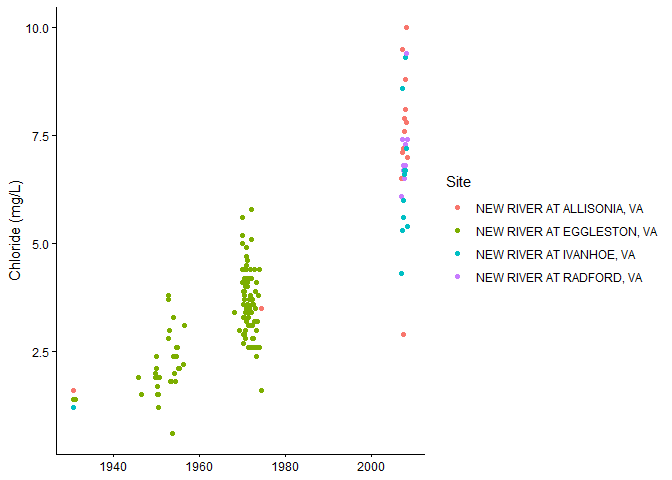

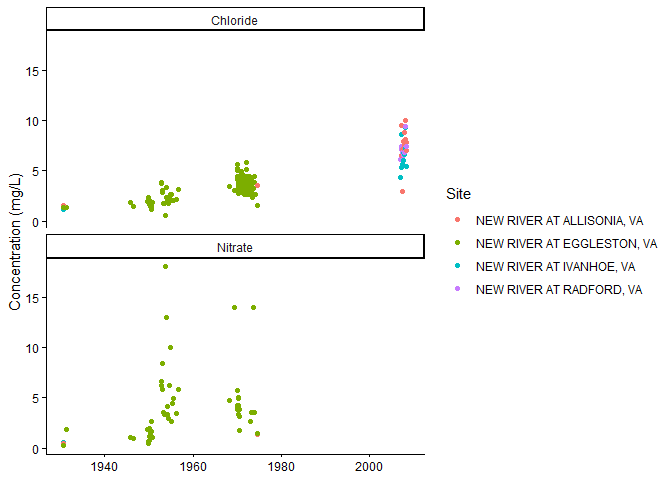

In [ ]:
wqdat_clean <- wqdat |> 
  left_join(swva_chem_sites, 
            by = c("MonitoringLocationIdentifier" = "site_no_USGS")) |>
  select(MonitoringLocationIdentifier, ActivityStartDate,
         CharacteristicName, ResultMeasure.MeasureUnitCode, 
         station_nm, ResultMeasureValue) |>
  filter(str_detect(station_nm, "NEW RIVER"))
  
wqdat_clean |> filter(CharacteristicName == "Chloride") |>
  ggplot(aes(x = ActivityStartDate, y = ResultMeasureValue, color = station_nm)) +
  geom_point()+
  ylab("Chloride (mg/L)")+
  xlab(element_blank())+
  labs(color = "Site")+
  theme_classic()

Now let’s say we want to calculate something with chloride and nitrate.
We need to make the data wide so we have a nitrate column and a chloride
column. Do that below. What goes into values_from? what goes into
names_from?

Next, plot Chloride and Nitrate added together (Chloride + Nitrate).
Could you do this with the data in the previous format?

Finally, use pivot_longer to transform the data back into a long format.
Often you’ll get data in a wide format and need to convert it to long,
and we haven’t tried that yet. The only argument you’ll need to pass to
pivot_longer() in this case is to tell it what columns to turn into the
new DATA column (using the cols = ) parameter.

(`geom_point()`).

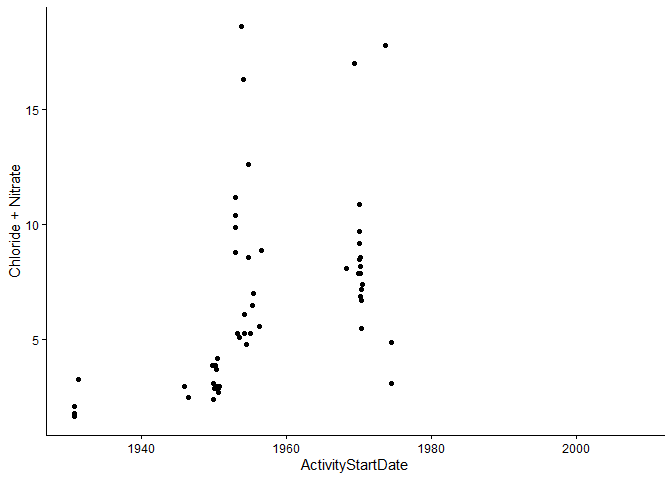

In [ ]:
#make wqdat_clean wide

wqdat_wide <- wqdat_clean |> select(-ResultMeasure.MeasureUnitCode) |>
  pivot_wider(values_from = ResultMeasureValue, names_from = CharacteristicName)

ggplot(wqdat_wide, aes(x = ActivityStartDate, y = Chloride + Nitrate)) +
  geom_point()+
  theme_classic()